# Let's use the Deep Purple lysics to train a LSTM simulated Deep Purple write lyrics automatically (Rock!!)

## This is simle LSTM model for text generator, for beginning of Pytorch.

* Model : Embedding layer (no pretrain) + LSTM (GPU on)
* Enviroment  : Pytorch 
* This kernel is for beginning of pytorch

## Using Sergey Kuznetsov's dataset - "55000+ Song Lyrics" : https://www.kaggle.com/mousehead/songlyrics

## Load and process data

In [1]:
import numpy as np
import pandas as pd
import random
import sys
import os

os.listdir('../input')

['songdata.csv']

In [2]:
# Read the entire file containing song lyrics
path = "../input/songdata.csv"
df = pd.read_csv(path)
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [3]:
# See all artist in this dataset
df['artist'].unique()

array(['ABBA', 'Ace Of Base', 'Adam Sandler', 'Adele', 'Aerosmith',
       'Air Supply', 'Aiza Seguerra', 'Alabama', 'Alan Parsons Project',
       'Aled Jones', 'Alice Cooper', 'Alice In Chains', 'Alison Krauss',
       'Allman Brothers Band', 'Alphaville', 'America', 'Amy Grant',
       'Andrea Bocelli', 'Andy Williams', 'Annie', 'Ariana Grande',
       'Ariel Rivera', 'Arlo Guthrie', 'Arrogant Worms', 'Avril Lavigne',
       'Backstreet Boys', 'Barbie', 'Barbra Streisand', 'Beach Boys',
       'The Beatles', 'Beautiful South', 'Beauty And The Beast',
       'Bee Gees', 'Bette Midler', 'Bill Withers', 'Billie Holiday',
       'Billy Joel', 'Bing Crosby', 'Black Sabbath', 'Blur', 'Bob Dylan',
       'Bob Marley', 'Bob Rivers', 'Bob Seger', 'Bon Jovi', 'Boney M.',
       'Bonnie Raitt', 'Bosson', 'Bread', 'Britney Spears',
       'Bruce Springsteen', 'Bruno Mars', 'Bryan White', 'Cake',
       'Carly Simon', 'Carol Banawa', 'Carpenters', 'Cat Stevens',
       'Celine Dion', 'Chaka Khan

### Let's focus on Deep Purple lyrics !!

In [4]:
DP = df[df['artist']=='Deep Purple']

In [5]:
DP.head()

,artist,song,link,text
3950,Deep Purple,Anya,/d/deep+purple/anya_20038833.html,I'm so far away from everything you know \nYo...
3951,Deep Purple,Back To Back,/d/deep+purple/back+to+back_20692130.html,I read in the news \nThat the average man \n...
3952,Deep Purple,Bad Attitude,/d/deep+purple/bad+attitude_20038850.html,Take a look at \nThese dirty hands \nTake a ...
3953,Deep Purple,Bird Has Flown,/d/deep+purple/bird+has+flown_20038690.html,Oh the beggar on his cornerstone \nCatches pi...
3954,Deep Purple,Black Night,/d/deep+purple/black+night_20038860.html,"Black night is not right, \nI don't feel so b..."


## Process the data
* Only keep the lyrics , merge all raws.

In [6]:
DP_text = DP['text'].str.cat(sep='\n').lower()

print(DP_text[:100])
print('corpus length:', len(DP_text))

i'm so far away from everything you know  
your name is carried, carried on the wind  
oh your ice b
corpus length: 176743


* Count the characters appered in all lyrics

In [7]:
chars = sorted(list(set(DP_text)))
print(chars)
print('total chars:', len(chars))

['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '6', '8', '9', ':', '?', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
total chars: 47


## Creates the sentence window and target characters
* Create dictionary of characters
* Create the sentence window
* Target is the next character of sentence window



In [8]:
# Create a dictionary of characters, see the index of characters.
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

print(char_to_int)

{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '6': 14, '8': 15, '9': 16, ':': 17, '?': 18, '[': 19, ']': 20, 'a': 21, 'b': 22, 'c': 23, 'd': 24, 'e': 25, 'f': 26, 'g': 27, 'h': 28, 'i': 29, 'j': 30, 'k': 31, 'l': 32, 'm': 33, 'n': 34, 'o': 35, 'p': 36, 'q': 37, 'r': 38, 's': 39, 't': 40, 'u': 41, 'v': 42, 'w': 43, 'x': 44, 'y': 45, 'z': 46}


In [9]:
seq_length = 50 # The sentence window size
step = 1 # The steps between the windows
sentences = []
next_chars = []

# Create Target and sentences window
for i in range(0, len(DP_text) - seq_length, step):
    sentences.append(DP_text[i: i + seq_length]) # range from current index to sequence length charaters 
    next_chars.append(DP_text[i + seq_length]) # the next character
    
sentences = np.array(sentences)
next_chars = np.array(next_chars)

#Print Sentence Window and next charaters
print('Sentence Window')
print (sentences[:5])
print('Target charaters')
print (next_chars[:5])
print('Number of sequences:', len(sentences))

Sentence Window
["i'm so far away from everything you know  \nyour na"
 "'m so far away from everything you know  \nyour nam"
 'm so far away from everything you know  \nyour name'
 ' so far away from everything you know  \nyour name '
 'so far away from everything you know  \nyour name i']
Target charaters
['m' 'e' ' ' 'i' 's']
Number of sequences: 176693


## Tranfer the character to index
* For pytorch, we don't need to use one-hot-vector

In [10]:
def getdata(sentences, next_chars):
    X = np.zeros((len(sentences),seq_length))
    y = np.zeros((len(sentences)))
    length = len(sentences)
    index = 0
    for i in range(len(sentences)):
        sentence = sentences[i]
        for t, char in enumerate(sentence):
            X[i, t] = char_to_int[char]
        y[i] = char_to_int[next_chars[i]]
    return X, y

In [11]:
train_x,train_y = getdata(sentences, next_chars)
print('Shape of training_x:', train_x.shape)
print('Shape of training_y:', train_y.shape)

Shape of training_x: (176693, 50)
Shape of training_y: (176693,)


## Build the model (Pytorch)
* Embedding layer : transfer index to embedding vector
* Simple LSTM + dropout : Sequence data to hidden states , dropout for prevent overfitting
* Fully connection layer : linear tranfer to a n_vocab vector to be output layer.

### P.S we don't need to do softmax here, we will do it when we calculate loss function 

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class Simple_LSTM(nn.Module):
    def __init__(self,n_vocab,hidden_dim, embedding_dim,dropout = 0.2):
        super(Simple_LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,dropout = dropout,num_layers = 2)
        self.embeddings = nn.Embedding(n_vocab, embedding_dim)
        self.fc = nn.Linear(hidden_dim, n_vocab)
    
    def forward(self, seq_in):
        # for LSTM, input should be (Sequnce_length,batchsize,hidden_layer), so we need to transpose the input
        embedded = self.embeddings(seq_in.t()) 
        lstm_out, _ = self.lstm(embedded)
        # Only need to keep the last character 
        ht=lstm_out[-1] 
        out = self.fc(ht)
        return out

## Create DataLoader of mini-batch training
* use GPU to training

In [13]:
X_train_tensor = torch.tensor(train_x, dtype=torch.long).cuda()
Y_train_tensor = torch.tensor(train_y, dtype=torch.long).cuda()

In [14]:
from torch.utils.data import Dataset, DataLoader
train = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size = 128)

## Start training
* Hidden_size : 256
* Embedding_size : 256
* Use Adam optimizer

In [15]:
model = Simple_LSTM(47,256,256)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002) # Using Adam optimizer

In [16]:
import time # Add time counter
avg_losses_f = []
n_epochs=20

for epoch in range(n_epochs):
    start_time = time.time()
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    avg_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        y_pred = model(x_batch)
        
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        avg_loss+= loss.item()/len(train_loader)
        
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss, elapsed_time))
    
    avg_losses_f.append(avg_loss)    
    
print('All \t loss={:.4f} \t '.format(np.average(avg_losses_f)))

Epoch 1/20 	 loss=1.7801 	 time=56.44s
Epoch 2/20 	 loss=1.4910 	 time=56.52s
Epoch 3/20 	 loss=1.3913 	 time=56.52s
Epoch 4/20 	 loss=1.3279 	 time=56.56s
Epoch 5/20 	 loss=1.2821 	 time=56.62s
Epoch 6/20 	 loss=1.2412 	 time=56.51s
Epoch 7/20 	 loss=1.2111 	 time=56.67s
Epoch 8/20 	 loss=1.1839 	 time=56.59s
Epoch 9/20 	 loss=1.1598 	 time=56.58s
Epoch 10/20 	 loss=1.1383 	 time=56.59s
Epoch 11/20 	 loss=1.1228 	 time=56.59s
Epoch 12/20 	 loss=1.1090 	 time=56.72s
Epoch 13/20 	 loss=1.0920 	 time=56.70s
Epoch 14/20 	 loss=1.0788 	 time=56.66s
Epoch 15/20 	 loss=1.0684 	 time=56.54s
Epoch 16/20 	 loss=1.0575 	 time=56.50s
Epoch 17/20 	 loss=1.0495 	 time=56.36s
Epoch 18/20 	 loss=1.0438 	 time=56.51s
Epoch 19/20 	 loss=1.0359 	 time=56.50s
Epoch 20/20 	 loss=1.0317 	 time=56.65s
All 	 loss=1.1948 	 


## Let's see training procedure by plot trend of loss value

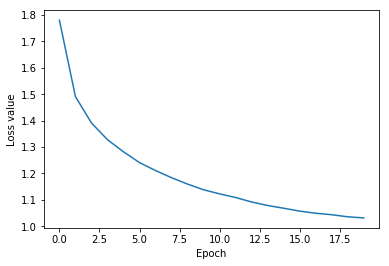

In [17]:
import matplotlib.pyplot as plt

plt.plot(avg_losses_f)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

## Create the function that can sample an index from a probability array
* This function is to prevent the most likely chracter always be chosen.

In [18]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

## Validate the model
* Define the 50 start sentence legth
* Predict next char
* Total create 400 characters lyrics

In [19]:
# Define the start sentence
sentence = 'i read in the news\nthat the average man\nplease kis'

variance = 0.25
generated = ''
original = sentence
window = sentence

for i in range(400):
    x = np.zeros((1, seq_length))
    for t, char in enumerate(window):
        x[0, t] = char_to_int[char] # Change the sentence to index vector shape (1,50)
        
    x_in = Variable(torch.LongTensor(x).cuda())
    pred = model(x_in)
    pred = np.array(F.softmax(pred, dim=1).data[0].cpu())
    next_index = sample(pred, variance)
    next_char = int_to_char[next_index] # index to char

    generated += next_char
    window = window[1:] + next_char # Update Window for next char predict
    
print(original + generated)

i read in the news
that the average man
please kiss  
the way you were a time for the ground  
i can't take your mind  
i couldn't get my mind  
when the way my friends  
when i walk on the world  
  
when i shouldn't go again  
i'm a man who was mine  
i can't see what you love me  
when you shouldn't take the door  
when i was right  
  
i can't be the ground  
i'm a while, i want to know  
what i want you what you can do  
  
she was a driving


## Conclusion
* Some sentence are not too meaningful, but looks words are correct, maybe we can do more process on data, or ensemble more differnt model...
* I am very curious, DL for CV, have conditional GAN, how about NLP? Can we add condition to LSTM for training?
* For example, In this dataset, we have differnt artist lyrics, could we give the artist condition, then, we can generate the artist style lyric by condition that we give, That will be very interesting!!